# SURVIVAL ANALYSIS - PHASE 2
## EXPLORATORY DATA ANALYSIS + DATA CLEANING

**Objective**: Transform raw CSVs → Single clean dataset ready for survival analysis

**Output**: `startup_survival_clean.csv` (ready for Cox/KM analysis)


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# PATHS
BASE_PATH = Path('/Users/danieleparini/Desktop/Advanced Data Analysis/Project Data/data')
OUTPUT_DIR = Path('/Users/danieleparini/Desktop/Advanced Data Analysis/Project Data/output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# CENSORING DATES
CRUNCHBASE_CENSOR = date(2013, 12, 31)  # Kaggle Crunchbase snapshot
FINAL_CENSOR = date(2024, 12, 31)       # Final observation

print('✓ Libraries imported')
print(f'✓ Base path: {BASE_PATH}')
print(f'✓ Output: {OUTPUT_DIR}')

✓ Libraries imported
✓ Base path: /Users/danieleparini/Desktop/Advanced Data Analysis/Project Data/data
✓ Output: /Users/danieleparini/Desktop/Advanced Data Analysis/Project Data/output


In [76]:
print('='*70)
print('PART 1: LOADING CRUNCHBASE 2013 (KAGGLE)')
print('='*70 + '\n')

# Load main objects table
print('[1/6] Loading objects.csv...')
objects = pd.read_csv(BASE_PATH / 'objects.csv', low_memory=False)
print(f'  Objects: {len(objects):,} rows')

# Filter: only companies
companies = objects[objects['entity_type'] == 'Company'].copy()
print(f'  Companies: {len(companies):,}')

# Load funding rounds
print('\n[2/6] Loading funding_rounds.csv...')
funding = pd.read_csv(BASE_PATH / 'funding_rounds.csv', low_memory=False)
print(f'  Funding rounds: {len(funding):,}')

# Load acquisitions
print('\n[3/6] Loading acquisitions.csv...')
acquisitions = pd.read_csv(BASE_PATH / 'acquisitions.csv', low_memory=False)
print(f'  Acquisitions: {len(acquisitions):,}')

# Load IPOs
print('\n[4/6] Loading ipos.csv...')
ipos_cb = pd.read_csv(BASE_PATH / 'ipos.csv', low_memory=False)
print(f'  IPOs: {len(ipos_cb):,}')

# Load people
print('\n[5/6] Loading people.csv...')
people = pd.read_csv(BASE_PATH / 'people.csv', low_memory=False)
print(f'  People: {len(people):,}')

# Load offices
print('\n[6/6] Loading offices.csv...')
offices = pd.read_csv(BASE_PATH / 'offices.csv', low_memory=False)
print(f'  Offices: {len(offices):,}')

print('\n✓ Crunchbase 2013 loaded!')

PART 1: LOADING CRUNCHBASE 2013 (KAGGLE)

[1/6] Loading objects.csv...
  Objects: 462,651 rows
  Companies: 196,553

[2/6] Loading funding_rounds.csv...
  Funding rounds: 52,928

[3/6] Loading acquisitions.csv...
  Acquisitions: 9,562

[4/6] Loading ipos.csv...
  IPOs: 1,259

[5/6] Loading people.csv...
  People: 226,709

[6/6] Loading offices.csv...
  Offices: 112,718

✓ Crunchbase 2013 loaded!


In [77]:
print('='*70)
print('PART 2: CLEANING CRUNCHBASE 2013')
print('='*70 + '\n')

# Clean companies
print('[1/6] Cleaning companies...')
companies_clean = companies.copy()
companies_clean['founded_at'] = pd.to_datetime(companies_clean['founded_at'], errors='coerce')
companies_clean['closed_at'] = pd.to_datetime(companies_clean['closed_at'], errors='coerce')
companies_clean = companies_clean[companies_clean['founded_at'].notna()]
companies_clean['founded_year'] = companies_clean['founded_at'].dt.year
companies_clean = companies_clean[companies_clean['founded_year'] >= 1975]
companies_clean = companies_clean[companies_clean['founded_year'] <= 2013]
print(f'  After cleaning: {len(companies_clean):,} companies')

# Clean funding
print('\n[2/6] Aggregating funding...')
funding_clean = funding.copy()
funding_clean['funded_at'] = pd.to_datetime(funding_clean['funded_at'], errors='coerce')
funding_clean['raised_amount_usd'] = pd.to_numeric(funding_clean['raised_amount_usd'], errors='coerce')
funding_clean = funding_clean.dropna(subset=['funded_at', 'object_id'])

funding_agg = funding_clean.groupby('object_id').agg({
    'funded_at': 'min',
    'raised_amount_usd': 'sum',
    'object_id': 'size'
}).rename(columns={
    'funded_at': 'first_funding_date',
    'raised_amount_usd': 'total_funding_usd',
    'object_id': 'num_rounds'
})
print(f'  Funding aggregated: {len(funding_agg):,} companies')

# Clean acquisitions
print('\n[3/6] Processing acquisitions...')
acq_clean = acquisitions.copy()
acq_clean['acquired_at'] = pd.to_datetime(acq_clean['acquired_at'], errors='coerce')
acq_clean = acq_clean.dropna(subset=['acquired_at', 'acquired_object_id'])
acq_dates = acq_clean[['acquired_object_id', 'acquired_at']].drop_duplicates(subset=['acquired_object_id'])
acq_dates = acq_dates.rename(columns={'acquired_object_id': 'id', 'acquired_at': 'ma_date'})
print(f'  M&A dates: {len(acq_dates):,}')

# Clean IPOs
print('\n[4/6] Processing IPOs...')
ipo_clean = ipos_cb.copy()
ipo_clean['public_at'] = pd.to_datetime(ipo_clean['public_at'], errors='coerce')
ipo_clean = ipo_clean.dropna(subset=['public_at', 'object_id'])
ipo_dates = ipo_clean[['object_id', 'public_at']].drop_duplicates(subset=['object_id'])
ipo_dates = ipo_dates.rename(columns={'object_id': 'id', 'public_at': 'ipo_date'})
print(f'  IPO dates: {len(ipo_dates):,}')

# Founders count
print('\n[5/6] Counting founders...')
founders_per_company = people.groupby('object_id').size().reset_index(name='num_founders')
founders_per_company = founders_per_company.rename(columns={'object_id': 'id'})
print(f'  Companies with people data: {len(founders_per_company):,}')

# Geography
print('\n[6/6] Extracting geography...')
offices_first = offices.drop_duplicates(subset=['object_id'], keep='first')
geo = offices_first[['object_id', 'country_code']].rename(columns={'object_id': 'id', 'country_code': 'country'})
print(f'  Companies with geography: {len(geo):,}')

print('\n✓ Crunchbase aggregation complete!')

PART 2: CLEANING CRUNCHBASE 2013

[1/6] Cleaning companies...
  After cleaning: 89,704 companies

[2/6] Aggregating funding...
  Funding aggregated: 31,735 companies

[3/6] Processing acquisitions...
  M&A dates: 9,383

[4/6] Processing IPOs...
  IPO dates: 659

[5/6] Counting founders...
  Companies with people data: 226,709

[6/6] Extracting geography...
  Companies with geography: 95,043

✓ Crunchbase aggregation complete!


In [78]:
print('='*70)
print('BUILDING CRUNCHBASE MASTER')
print('='*70 + '\n')

# Base dataset
master_cb = companies_clean[['id', 'name', 'category_code', 'founded_at', 'closed_at']].copy()
master_cb = master_cb.rename(columns={'name': 'company_name', 'category_code': 'sector'})

# Merge funding
master_cb = master_cb.merge(funding_agg, how='left', left_on='id', right_index=True)

# Merge founders
master_cb = master_cb.merge(founders_per_company, how='left', on='id')
master_cb['num_founders'] = master_cb['num_founders'].fillna(0).astype(int)

# Merge geography
master_cb = master_cb.merge(geo, how='left', on='id')

# Merge M&A dates
master_cb = master_cb.merge(acq_dates, how='left', on='id')

# Merge IPO dates
master_cb = master_cb.merge(ipo_dates, how='left', on='id')

# Determine exit type
master_cb['exit_type'] = 'Censored'
master_cb.loc[master_cb['ma_date'].notna(), 'exit_type'] = 'M&A'
master_cb.loc[master_cb['ipo_date'].notna(), 'exit_type'] = 'IPO'
master_cb['event'] = (master_cb['exit_type'] != 'Censored').astype(int)

# Dates
master_cb['start_date'] = master_cb['founded_at'] + pd.DateOffset(years=1)

def get_end_date_cb(row):
    if pd.notna(row['ipo_date']):
        return row['ipo_date']
    elif pd.notna(row['ma_date']):
        return row['ma_date']
    elif pd.notna(row['closed_at']):
        return row['closed_at']
    else:
        return pd.Timestamp(CRUNCHBASE_CENSOR)

master_cb['end_date'] = master_cb.apply(get_end_date_cb, axis=1)

# Duration
master_cb['duration_days'] = (master_cb['end_date'] - master_cb['start_date']).dt.days
master_cb['duration_years'] = master_cb['duration_days'] / 365.25

# Filter
master_cb = master_cb[master_cb['duration_years'] > 0]
master_cb = master_cb[master_cb['duration_years'] <= 50]
master_cb = master_cb.drop_duplicates(subset=['id'])

# Source
master_cb['source'] = 'Crunchbase_2013'
master_cb['id'] = 'CB_' + master_cb['id'].astype(str)

print(f'Crunchbase Master: {len(master_cb):,} companies')
print(f'\nExit distribution:')
print(master_cb['exit_type'].value_counts())
print(f'\nEvent rate: {master_cb["event"].mean()*100:.1f}%')
print(f'Duration - Mean: {master_cb["duration_years"].mean():.2f} years')

BUILDING CRUNCHBASE MASTER

Crunchbase Master: 83,412 companies

Exit distribution:
exit_type
Censored    78630
M&A          4429
IPO           353
Name: count, dtype: int64

Event rate: 5.7%
Duration - Mean: 6.32 years


In [79]:
print('\n' + '='*70)
print('PART 3: LOADING Y COMBINATOR 2023')
print('='*70 + '\n')

yc = pd.read_csv(BASE_PATH / '2023-07-13-yc-companies.csv', low_memory=False)
print(f'YC loaded: {len(yc):,} companies')

# Clean
yc_clean = yc.copy()
yc_clean['year_founded'] = pd.to_numeric(yc_clean['year_founded'], errors='coerce')
yc_clean = yc_clean[yc_clean['year_founded'] >= 1995]
yc_clean = yc_clean[yc_clean['company_name'].notna()]

print(f'After cleaning: {len(yc_clean):,}')


PART 3: LOADING Y COMBINATOR 2023

YC loaded: 8,410 companies
After cleaning: 6,211


In [80]:
print('BUILDING Y COMBINATOR MASTER...\n')

master_yc = yc_clean[['company_id', 'company_name', 'year_founded', 'status', 'tags', 'team_size', 'country']].copy()
master_yc = master_yc.rename(columns={'company_id': 'id', 'tags': 'sector'})
master_yc['id'] = 'YC_' + master_yc['id'].astype(str)

# Exit classification
master_yc['exit_type'] = 'Censored'
master_yc.loc[master_yc['status'].str.contains('Acquired', case=False, na=False), 'exit_type'] = 'M&A'
master_yc.loc[master_yc['status'].str.contains('IPO', case=False, na=False), 'exit_type'] = 'IPO'
master_yc['event'] = (master_yc['exit_type'] != 'Censored').astype(int)

# Dates
master_yc['start_date'] = pd.to_datetime(
    master_yc['year_founded'].astype(int).astype(str) + '-01-01'
) + pd.DateOffset(years=1)
master_yc['end_date'] = pd.Timestamp(FINAL_CENSOR)

# Duration
master_yc['duration_days'] = (master_yc['end_date'] - master_yc['start_date']).dt.days
master_yc['duration_years'] = master_yc['duration_days'] / 365.25

# Filter
master_yc = master_yc[master_yc['duration_years'] > 0]
master_yc = master_yc[master_yc['duration_years'] <= 50]
master_yc = master_yc.drop_duplicates(subset=['id'])

# Source
master_yc['source'] = 'Y_Combinator'

# Placeholder cols
master_yc['founded_at'] = master_yc['start_date'] - pd.DateOffset(years=1)
master_yc['total_funding_usd'] = np.nan
master_yc['num_rounds'] = np.nan
master_yc['num_founders'] = np.nan
master_yc['first_funding_date'] = np.nan
master_yc['ipo_date'] = np.nan
master_yc['ma_date'] = np.nan
master_yc['closed_at'] = np.nan

print(f'YC Master: {len(master_yc):,} companies')
print(f'\nExit distribution:')
print(master_yc['exit_type'].value_counts())
print(f'\nEvent rate: {master_yc["event"].mean()*100:.1f}%')

BUILDING Y COMBINATOR MASTER...

YC Master: 3,197 companies

Exit distribution:
exit_type
Censored    2959
M&A          238
Name: count, dtype: int64

Event rate: 7.4%


In [81]:
print('\n' + '='*70)
print('PART 4: LOADING JAY RITTER IPO DATABASE')
print('='*70 + '\n')

ritter = pd.read_excel(BASE_PATH / 'IPO-age.xlsx', sheet_name='1975-2024')
print(f'Ritter loaded: {len(ritter):,} IPOs')

# IMPORTANT: Print columns to see actual names
print(f'\nColumns in file: {ritter.columns.tolist()[:10]}...')

# Clean (column names from your file)
ritter_clean = ritter.copy()

# Use exact column names you listed
ritter_clean['offer_date'] = pd.to_datetime(ritter_clean['offer date'], errors='coerce')
ritter_clean['founding_year'] = pd.to_numeric(ritter_clean['Founding'], errors='coerce')
ritter_clean['ipo_name'] = ritter_clean['IPO name']

# Filter valid rows and years
ritter_clean = ritter_clean.dropna(subset=['offer_date', 'founding_year'])
ritter_clean = ritter_clean[(ritter_clean['founding_year'] >= 1975) & (ritter_clean['founding_year'] <= 2024)]


print(f'After cleaning: {len(ritter_clean):,}')



PART 4: LOADING JAY RITTER IPO DATABASE

Ritter loaded: 15,697 IPOs

Columns in file: ['offer date', 'IPO name', 'Ticker', 'CUSIP', 'ADR (2=ADR)', 'VC', 'Dual', 'Post-issue shares', 'Internet', 'CRSP Perm']...
After cleaning: 10,630


In [82]:
# ======================================================================
# PART 4: LOADING JAY RITTER IPO DATABASE
# ======================================================================

print('\n' + '='*70)
print('PART 4: LOADING JAY RITTER IPO DATABASE')
print('='*70 + '\n')

# Load
ritter = pd.read_excel(BASE_PATH / 'IPO-age.xlsx', sheet_name='1975-2024')
print(f'Ritter loaded: {len(ritter):,} IPOs')

# Debug: columns
print(f'\nColumns in file: {ritter.columns.tolist()[:12]}...')

# -----------------------------
# CLEANING (robust date parsing)
# -----------------------------
ritter_clean = ritter.copy()

# Parse offer date from 8-digit YYYYMMDD (may be numeric/float/string)
offer_raw = ritter_clean['offer date'].astype(str).str.strip()
offer_raw = offer_raw.str.replace(r'\.0$', '', regex=True)                 # drop trailing .0
offer_8   = offer_raw.str.extract(r'(?P<d>\d{8})')['d']                    # keep 8-digit dates
ritter_clean['offer_date'] = pd.to_datetime(offer_8, format='%Y%m%d', errors='coerce')

# Founding year and IPO name
ritter_clean['founding_year'] = pd.to_numeric(ritter_clean['Founding'], errors='coerce')
name_col = 'IPO name' if 'IPO name' in ritter_clean.columns else None
ritter_clean['ipo_name'] = ritter_clean[name_col].astype(str).str.strip() if name_col else np.nan

# Filter valid rows and sensible years
ritter_clean = ritter_clean.dropna(subset=['offer_date', 'founding_year'])
ritter_clean = ritter_clean[(ritter_clean['founding_year'] >= 1975) & (ritter_clean['founding_year'] <= 2024)]

print(f'After cleaning: {len(ritter_clean):,}')
print(ritter_clean[['offer_date','founding_year']].isna().mean())

# --------------------------------
# BUILDING JAY RITTER MASTER
# --------------------------------
print('\nBUILDING JAY RITTER MASTER...\n')

master_ritter = pd.DataFrame({
    'id': 'RITTER_' + ritter_clean.index.astype(str),
    'company_name': ritter_clean['ipo_name'],
    'sector': np.nan,
    'country': 'USA',
    'exit_type': 'IPO',
    'event': 1,
    'source': 'Jay_Ritter'
})

# Dates: start at Jan 1 of founding year (no +1 year)
master_ritter['founded_at'] = pd.to_datetime(
    ritter_clean['founding_year'].astype(int).astype(str) + '-01-01',
    errors='coerce'
)
master_ritter['start_date'] = master_ritter['founded_at']
master_ritter['end_date']   = ritter_clean['offer_date'].values
master_ritter['ipo_date']   = master_ritter['end_date']

# Duration: allow same-year IPO; drop only negative or null; cap at 50y
master_ritter['duration_days']  = (master_ritter['end_date'] - master_ritter['start_date']).dt.days
master_ritter = master_ritter[master_ritter['duration_days'].notna()]
master_ritter = master_ritter[master_ritter['duration_days'] >= 0]
master_ritter['duration_years'] = master_ritter['duration_days'] / 365.25
master_ritter = master_ritter[master_ritter['duration_years'] <= 50]

# Drop empty names if any
master_ritter = master_ritter[master_ritter['company_name'].str.len() > 0]

# Placeholders for schema alignment
master_ritter['team_size'] = np.nan
master_ritter['total_funding_usd'] = np.nan
master_ritter['num_rounds'] = np.nan
master_ritter['num_founders'] = np.nan
master_ritter['first_funding_date'] = np.nan
master_ritter['ma_date'] = np.nan
master_ritter['closed_at'] = np.nan
master_ritter['status'] = 'IPO'

# Report
print(f'Ritter Master: {len(master_ritter):,} IPOs')
mean_years = master_ritter['duration_years'].mean()
print(f'Duration - Mean: {mean_years:.2f} years')
print(master_ritter.head(3)[['company_name','founded_at','ipo_date','duration_years']])



PART 4: LOADING JAY RITTER IPO DATABASE

Ritter loaded: 15,697 IPOs

Columns in file: ['offer date', 'IPO name', 'Ticker', 'CUSIP', 'ADR (2=ADR)', 'VC', 'Dual', 'Post-issue shares', 'Internet', 'CRSP Perm', 'Founding', 'Rollup']...
After cleaning: 10,630
offer_date       0.0
founding_year    0.0
dtype: float64

BUILDING JAY RITTER MASTER...

Ritter Master: 10,630 IPOs
Duration - Mean: 7.26 years
              company_name founded_at   ipo_date  duration_years
36     CHEFS INTERNATIONAL 1975-01-01 1976-10-29        1.826146
46         ST JUDE MEDICAL 1976-01-01 1977-02-09        1.108830
54  DELOREAN MOTOR CORPORA 1975-01-01 1977-06-29        2.491444


In [84]:
print('BUILDING JAY RITTER MASTER...\n')

master_ritter = pd.DataFrame({
    'id': 'RITTER_' + ritter_clean.index.astype(str),
    'company_name': ritter_clean['IPO name'],
    'sector': np.nan,
    'country': 'USA',
    'exit_type': 'IPO',
    'event': 1,
    'source': 'Jay_Ritter'
})

master_ritter['founded_at'] = pd.to_datetime(
    ritter_clean['founding_year'].astype(int).astype(str) + '-01-01'
)
master_ritter['start_date'] = master_ritter['founded_at'] + pd.DateOffset(years=1)
master_ritter['end_date'] = ritter_clean['offer_date'].values
master_ritter['ipo_date'] = master_ritter['end_date']

# Duration
master_ritter['duration_days'] = (master_ritter['end_date'] - master_ritter['start_date']).dt.days
master_ritter['duration_years'] = master_ritter['duration_days'] / 365.25

# Filter
master_ritter = master_ritter[master_ritter['duration_years'] > 0]
master_ritter = master_ritter[master_ritter['duration_years'] <= 50]

# Placeholder cols
master_ritter['status'] = 'IPO'
master_ritter['team_size'] = np.nan
master_ritter['total_funding_usd'] = np.nan
master_ritter['num_rounds'] = np.nan
master_ritter['num_founders'] = np.nan
master_ritter['first_funding_date'] = np.nan
master_ritter['ma_date'] = np.nan
master_ritter['closed_at'] = np.nan

print(f'Ritter Master: {len(master_ritter):,} IPOs')
print(f'Duration - Mean: {master_ritter["duration_years"].mean():.2f} years')

BUILDING JAY RITTER MASTER...

Ritter Master: 9,419 IPOs
Duration - Mean: 7.11 years


In [85]:
print('\n' + '='*70)
print('PART 5: COMBINING ALL DATASETS')
print('='*70 + '\n')

print('[1/3] Checking overlaps by name...')

# Get company names
cb_names = set(master_cb['company_name'].str.lower().str.strip())
yc_names = set(master_yc['company_name'].str.lower().str.strip())
ritter_names = set(master_ritter['company_name'].str.lower().str.strip())

overlap_yc_cb = yc_names & cb_names
overlap_ritter_cb = ritter_names & cb_names
overlap_ritter_yc = ritter_names & yc_names

print(f'  YC ∩ Crunchbase: {len(overlap_yc_cb):,}')
print(f'  Ritter ∩ Crunchbase: {len(overlap_ritter_cb):,}')
print(f'  Ritter ∩ YC: {len(overlap_ritter_yc):,}')

print('\n[2/3] Removing duplicates (priority: Crunchbase > YC > Ritter)...')

# Remove YC companies already in Crunchbase
master_yc_unique = master_yc[
    ~master_yc['company_name'].str.lower().str.strip().isin(cb_names)
].copy()
print(f'  YC unique: {len(master_yc_unique):,}')

# Remove Ritter companies already in Crunchbase or YC
all_existing = cb_names | yc_names
master_ritter_unique = master_ritter[
    ~master_ritter['company_name'].str.lower().str.strip().isin(all_existing)
].copy()
print(f'  Ritter unique: {len(master_ritter_unique):,}')

print('\n[3/3] Concatenating datasets...')

# Align columns
all_cols = list(set(
    master_cb.columns.tolist() + 
    master_yc.columns.tolist() + 
    master_ritter.columns.tolist()
))

for col in all_cols:
    if col not in master_cb.columns:
        master_cb[col] = np.nan
    if col not in master_yc_unique.columns:
        master_yc_unique[col] = np.nan
    if col not in master_ritter_unique.columns:
        master_ritter_unique[col] = np.nan

# Concatenate
master_combined = pd.concat([
    master_cb,
    master_yc_unique,
    master_ritter_unique
], ignore_index=True)

print(f'\n{"="*70}')
print('COMBINED DATASET COMPLETE')
print(f'{"="*70}')
print(f'Crunchbase 2013: {len(master_cb):,}')
print(f'Y Combinator (unique): {len(master_yc_unique):,}')
print(f'Jay Ritter (unique): {len(master_ritter_unique):,}')
print(f'TOTAL: {len(master_combined):,}')

print(f'\nExit distribution:')
print(master_combined['exit_type'].value_counts())

print(f'\nEvent rate: {master_combined["event"].mean()*100:.1f}%')
print(f'Duration - Mean: {master_combined["duration_years"].mean():.2f} years')
print(f'Duration - Median: {master_combined["duration_years"].median():.2f} years')


PART 5: COMBINING ALL DATASETS

[1/3] Checking overlaps by name...
  YC ∩ Crunchbase: 199
  Ritter ∩ Crunchbase: 239
  Ritter ∩ YC: 2

[2/3] Removing duplicates (priority: Crunchbase > YC > Ritter)...
  YC unique: 2,992
  Ritter unique: 9,177

[3/3] Concatenating datasets...

COMBINED DATASET COMPLETE
Crunchbase 2013: 83,412
Y Combinator (unique): 2,992
Jay Ritter (unique): 9,177
TOTAL: 95,581

Exit distribution:
exit_type
Censored    81418
IPO          9530
M&A          4633
Name: count, dtype: int64

Event rate: 14.8%
Duration - Mean: 6.35 years
Duration - Median: 4.16 years


In [86]:
print('\n' + '='*70)
print('PART 6: FEATURE ENGINEERING')
print('='*70 + '\n')

master = master_combined.copy()

# Year founded
master['year_founded'] = master['founded_at'].dt.year

# Decade
master['decade'] = (master['year_founded'] // 10) * 10

# Post-2000
master['post_2000'] = (master['year_founded'] >= 2000).astype(int)

# Sector classification
def classify_sector(sector):
    if pd.isna(sector):
        return 'Other'
    sector_upper = str(sector).upper()
    if any(k in sector_upper for k in ['SOFTWARE', 'SAAS']):
        return 'Software'
    elif any(k in sector_upper for k in ['BIOTECH', 'HEALTH', 'MEDICAL']):
        return 'Healthcare'
    elif any(k in sector_upper for k in ['FINTECH', 'FINANCE']):
        return 'FinTech'
    elif any(k in sector_upper for k in ['AI', 'ML', 'MACHINE']):
        return 'AI/ML'
    else:
        return 'Other'

master['sector_clean'] = master['sector'].apply(classify_sector)
print(f'Sectors: {master["sector_clean"].value_counts().to_dict()}')

# Geography classification
def classify_geography(country):
    if pd.isna(country):
        return 'Other'
    country_upper = str(country).upper()
    if country_upper in ['US', 'USA', 'UNITED STATES']:
        return 'US'
    elif country_upper in ['GB', 'UK', 'UNITED KINGDOM']:
        return 'UK'
    elif country_upper in ['CA', 'CANADA']:
        return 'Canada'
    elif country_upper in ['CN', 'CHINA']:
        return 'China'
    else:
        return 'Other'

master['geography'] = master['country'].apply(classify_geography)
print(f'\nGeographies: {master["geography"].value_counts().to_dict()}')

# Funding indicators
master['has_funding'] = (master['total_funding_usd'].notna()).astype(int)
master['funding_log'] = np.log10(master['total_funding_usd'] + 1)

print('\n✓ Feature engineering complete!')


PART 6: FEATURE ENGINEERING

Sectors: {'Other': 75529, 'Software': 14512, 'Healthcare': 4091, 'FinTech': 1112, 'AI/ML': 337}

Geographies: {'Other': 48215, 'US': 47162, 'Canada': 101, 'UK': 100, 'China': 3}

✓ Feature engineering complete!


In [87]:
# ======================================================================
# PART 5A: NAME NORMALIZATION + DEDUP OVERLAP (ROBUST)
# ======================================================================
import re

def norm_name(s):
    if pd.isna(s): 
        return ''
    s = s.lower()
    s = re.sub(r'&', ' and ', s)
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)
    s = re.sub(r'\b(inc|corp|co|ltd|llc|plc|sa|ag|gmbh|bv|pte|srl|spa|oy|ab)\b', ' ', s)
    s = re.sub(r'\b(incorporated|corporation|company|limited)\b', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

for df, col in [(master_cb, 'company_name'), (master_yc, 'company_name'), (master_ritter, 'company_name')]:
    df['name_norm'] = df[col].apply(norm_name)

print('\n' + '='*70)
print('PART 5A: NORMALIZED OVERLAPS')
print('='*70 + '\n')

cb_names = set(master_cb['name_norm'])
yc_names = set(master_yc['name_norm'])
ritter_names = set(master_ritter['name_norm'])

overlap_yc_cb = yc_names & cb_names
overlap_ritter_cb = ritter_names & cb_names
overlap_ritter_yc = ritter_names & yc_names

print(f'  YC ∩ Crunchbase (norm): {len(overlap_yc_cb):,}')
print(f'  Ritter ∩ Crunchbase (norm): {len(overlap_ritter_cb):,}')
print(f'  Ritter ∩ YC (norm): {len(overlap_ritter_yc):,}')

master_yc_unique = master_yc[~master_yc['name_norm'].isin(cb_names)].copy()
print(f'\n  YC unique (norm): {len(master_yc_unique):,}')

existing_norm = cb_names | set(master_yc_unique['name_norm'])
master_ritter_unique = master_ritter[~master_ritter['name_norm'].isin(existing_norm)].copy()
print(f'  Ritter unique (norm): {len(master_ritter_unique):,}')




PART 5A: NORMALIZED OVERLAPS

  YC ∩ Crunchbase (norm): 218
  Ritter ∩ Crunchbase (norm): 1,075
  Ritter ∩ YC (norm): 11

  YC unique (norm): 2,972
  Ritter unique (norm): 8,331


In [88]:
# ======================================================================
# PART 5B: CONCAT + GEO FALLBACK + REPORT
# ======================================================================
print('\n[3/3] Concatenating datasets with normalized dedup...\n')

all_cols = list(set(
    master_cb.columns.tolist() + 
    master_yc_unique.columns.tolist() + 
    master_ritter_unique.columns.tolist()
))
for col in all_cols:
    if col not in master_cb.columns: master_cb[col] = np.nan
    if col not in master_yc_unique.columns: master_yc_unique[col] = np.nan
    if col not in master_ritter_unique.columns: master_ritter_unique[col] = np.nan

master_combined = pd.concat(
    [master_cb, master_yc_unique, master_ritter_unique],
    ignore_index=True
)

def classify_geography(country):
    if pd.isna(country): return 'Other'
    c = str(country).upper()
    if c in ['US', 'USA', 'UNITED STATES']: return 'US'
    if c in ['GB', 'UK', 'UNITED KINGDOM']: return 'UK'
    if c in ['CA', 'CANADA']: return 'Canada'
    if c in ['CN', 'CHINA']: return 'China'
    return 'Other'

# Fallback country: mappa da YC per chi ha country mancante
yc_geo_map = master_yc[['name_norm','country']].dropna().drop_duplicates().set_index('name_norm')['country'].to_dict()
mask_missing_country = master_combined['country'].isna()
master_combined.loc[mask_missing_country, 'country'] = master_combined.loc[mask_missing_country, 'name_norm'].map(yc_geo_map)
master_combined['country'] = master_combined['country'].fillna('US')
master_combined['geography'] = master_combined['country'].apply(classify_geography)

print('\n' + '='*70)
print('COMBINED DATASET (NORMALIZED) COMPLETE')
print('='*70)
print(f'Crunchbase 2013: {len(master_cb):,}')
print(f'Y Combinator (unique norm): {len(master_yc_unique):,}')
print(f'Jay Ritter (unique norm): {len(master_ritter_unique):,}')
print(f'TOTAL: {len(master_combined):,}')

print('\nExit distribution:')
print(master_combined['exit_type'].value_counts())

print(f"\nEvent rate: {master_combined['event'].mean()*100:.1f}%")
print(f"Duration - Mean: {master_combined['duration_years'].mean():.2f} years")
print(f"Duration - Median: {master_combined['duration_years'].median():.2f} years")

print('\nGeographies (top 6):')
print(master_combined['geography'].value_counts().head(6))

master = master_combined.copy()



[3/3] Concatenating datasets with normalized dedup...


COMBINED DATASET (NORMALIZED) COMPLETE
Crunchbase 2013: 83,412
Y Combinator (unique norm): 2,972
Jay Ritter (unique norm): 8,331
TOTAL: 94,715

Exit distribution:
exit_type
Censored    81400
IPO          8684
M&A          4631
Name: count, dtype: int64

Event rate: 14.1%
Duration - Mean: 6.33 years
Duration - Median: 4.08 years

Geographies (top 6):
geography
US        68096
Other     26416
Canada      100
UK          100
China         3
Name: count, dtype: int64


In [89]:
# ======================================================================
# DEDUP STRETTO SU NAME_NORM + DATE
# ======================================================================
before = len(master)

# Mantieni il record con source prioritario se stesso name_norm
source_priority = pd.CategoricalDtype(['Crunchbase_2013','Y_Combinator','Jay_Ritter'], ordered=True)
master['source'] = master['source'].astype(source_priority)

# Ordina per priorità fonte e data più precoce (opzionale)
master = master.sort_values(['name_norm','source','start_date','end_date'])

# Rimuovi duplicati stretti: stesso nome normalizzato e stesse date chiave
master = master.drop_duplicates(
    subset=['name_norm','start_date','ipo_date','ma_date'],
    keep='first'
).reset_index(drop=True)

after = len(master)
print(f'Dedup compressed: {before-after:,} rows removed (now {after:,})')

# Piccolo controllo duplicati residui su name_norm
dup_left = master.duplicated(subset=['name_norm'], keep=False).sum()
print(f'Residual duplicates on name_norm: {dup_left}')

Dedup compressed: 25 rows removed (now 94,690)
Residual duplicates on name_norm: 332


In [90]:
# ======================================================================
# PART 6: FEATURE ENGINEERING
# ======================================================================

import numpy as np
import pandas as pd

# Year founded from founded_at if missing
if 'year_founded' not in master.columns or master['year_founded'].isna().all():
    master['year_founded'] = pd.to_datetime(master['start_date']).dt.year - 1

# Decade bucket
master['decade'] = (master['year_founded'] // 10) * 10

# Post-2000 indicator
master['post_2000'] = (master['year_founded'] >= 2000).astype(int)

# Sector cleanup
def classify_sector(sector):
    if pd.isna(sector): return 'Other'
    s = str(sector).upper()
    if any(k in s for k in ['SOFTWARE','SAAS']): return 'Software'
    if any(k in s for k in ['BIOTECH','HEALTH','MEDICAL']): return 'Healthcare'
    if any(k in s for k in ['FINTECH','FINANCE','BANK']): return 'FinTech'
    if any(k in s for k in ['AI','ML','MACHINE LEARNING','ARTIFICIAL INTELLIGENCE']): return 'AI/ML'
    return 'Other'

# Prefer existing sector if presente, altrimenti normalizza
if 'sector_clean' not in master.columns:
    base_sector_col = 'sector' if 'sector' in master.columns else None
    master['sector_clean'] = master[base_sector_col].apply(classify_sector) if base_sector_col else 'Other'

# Funding signals
if 'total_funding_usd' not in master.columns:
    master['total_funding_usd'] = np.nan
master['has_funding'] = (master['total_funding_usd'].fillna(0) > 0).astype(int)
master['funding_log'] = np.log10(master['total_funding_usd'].fillna(0) + 1)

# Founders count (ensure consistent type)
if 'num_founders' in master.columns:
    master['num_founders'] = pd.to_numeric(master['num_founders'], errors='coerce').fillna(0).astype(int)
else:
    master['num_founders'] = 0

# Geography already computed; ensure consistent labels
def normalize_geo(g):
    if pd.isna(g): return 'Other'
    g = str(g)
    if g in ['US','USA','United States']: return 'US'
    if g in ['UK','GB','United Kingdom']: return 'UK'
    if g in ['CA','Canada']: return 'Canada'
    if g in ['CN','China']: return 'China'
    return 'Other'

master['geography'] = master['geography'].apply(normalize_geo)

# Final selection check
feature_cols_preview = [
    'id','company_name','name_norm','source',
    'start_date','end_date','duration_years','event','exit_type',
    'ipo_date','ma_date',
    'year_founded','decade','post_2000',
    'sector_clean','geography',
    'total_funding_usd','funding_log','num_rounds','num_founders'
]
present = [c for c in feature_cols_preview if c in master.columns]
print('\nFeature columns present:')
print(present)
print('\nFeature engineering complete!')


Feature columns present:
['id', 'company_name', 'name_norm', 'source', 'start_date', 'end_date', 'duration_years', 'event', 'exit_type', 'ipo_date', 'ma_date', 'year_founded', 'decade', 'post_2000', 'sector_clean', 'geography', 'total_funding_usd', 'funding_log', 'num_rounds', 'num_founders']

Feature engineering complete!


In [99]:
# ======================================================================
# PATCH: normalize geography from country (ISO-2/3 and names) 
# ======================================================================
import pandas as pd
import re

# 1) Normalizza country (trim, uppercase)
master['country'] = master['country'].astype(str).str.strip().str.upper()

# 2) Mappa completa ISO-3 → nome leggibile
iso3_map = {
    'USA':'US', 'GBR':'UK', 'CAN':'CANADA', 'CHN':'CHINA',
    'IND':'INDIA', 'ISR':'ISRAEL', 'DEU':'GERMANY', 'FRA':'FRANCE',
    'ESP':'SPAIN', 'ITA':'ITALY', 'NLD':'NETHERLANDS', 'AUS':'AUSTRALIA',
    'JPN':'JAPAN', 'KOR':'SOUTH KOREA', 'SGP':'SINGAPORE', 'HKG':'HONG KONG',
    'BRA':'BRAZIL', 'MEX':'MEXICO', 'IRL':'IRELAND', 'SWE':'SWEDEN',
    'NOR':'NORWAY', 'DNK':'DENMARK', 'FIN':'FINLAND', 'CHE':'SWITZERLAND',
    'AUT':'AUSTRIA', 'BEL':'BELGIUM', 'PRT':'PORTUGAL', 'POL':'POLAND',
    'CZE':'CZECH REPUBLIC', 'TUR':'TURKEY', 'ARE':'UAE', 'NZL':'NEW ZEALAND',
    'RUS':'RUSSIA', 'ZAF':'SOUTH AFRICA', 'ARG':'ARGENTINA', 'CHL':'CHILE',
    'COL':'COLOMBIA'
}

# 3) Converti ISO-3 → nome completo
master['country'] = master['country'].replace(iso3_map)

# 4) Mappa finale → geography
def to_geo(c):
    if pd.isna(c) or c == 'NAN': 
        return 'Other'
    u = str(c).upper().strip()
    if u in ['US', 'USA', 'UNITED STATES']:
        return 'US'
    if u in ['UK', 'GB', 'UNITED KINGDOM', 'GBR']:
        return 'UK'
    if u in ['CANADA', 'CA']:
        return 'Canada'
    if u in ['CHINA', 'CN']:
        return 'China'
    return 'Other'

master['geography'] = master['country'].apply(to_geo)

# 5) Verifica
print('Sample country→geography mapping:')
print(master.loc[master['country'].isin(['CHINA','CANADA','UK','GBR']), ['country','geography']].drop_duplicates().head(10))
print('\nGeography distribution:')
print(master['geography'].value_counts().head(10))



# 2) Sector enrichment: riconosci 'mobile' e altre macro-categorie
def classify_sector_enriched(s):
    if pd.isna(s): return 'Other'
    t = str(s).upper()
    if any(k in t for k in ['SOFTWARE','SAAS','MOBILE','APP','CLOUD']): return 'Software'
    if any(k in t for k in ['HEALTH','MEDICAL','BIO','BIOTECH','PHARMA']): return 'Healthcare'
    if any(k in t for k in ['FINTECH','FINANCE','BANK','PAYMENT','INSURTECH']): return 'FinTech'
    if any(k in t for k in ['AI','ML','MACHINE LEARNING','ARTIFICIAL INTELLIGENCE','DATA','NLP','VISION']): return 'AI/ML'
    return 'Other'

# Se hai già sector_clean, arricchisci solo gli 'Other'
if 'sector_clean' in master.columns:
    mask_other = master['sector_clean'].eq('Other')
    master.loc[mask_other, 'sector_clean'] = master.loc[mask_other, 'sector'].apply(classify_sector_enriched)
else:
    master['sector_clean'] = master['sector'].apply(classify_sector_enriched)

# 3) Company name unknown -> usa id come fallback e rigenera name_norm
def is_unknown_name(x):
    if pd.isna(x): return True
    s = str(x).strip().lower()
    return s in ['', '????', 'na', 'n/a', 'none', 'null']

mask_unknown = master['company_name'].apply(is_unknown_name)
master.loc[mask_unknown, 'company_name'] = master.loc[mask_unknown, 'id']

import re
def norm_name(s):
    if pd.isna(s): return ''
    s = s.lower()
    s = re.sub(r'&', ' and ', s)
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)
    s = re.sub(r'\b(inc|corp|co|ltd|llc|plc|sa|ag|gmbh|bv|pte|srl|spa|oy|ab)\b', ' ', s)
    s = re.sub(r'\b(incorporated|corporation|company|limited)\b', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

master['name_norm'] = master['company_name'].apply(norm_name)

print('Patch applied: geography, sector, names updated.')

print(master.loc[master['country'].isin(['CHN','CAN','GBR']) , ['country','geography']].head(10))
print(master['geography'].value_counts().head(10))


Sample country→geography mapping:
   country geography
1    CHINA     China
4   CANADA    Canada
45      UK        UK

Geography distribution:
geography
US        68080
Other     18326
UK         5098
Canada     2706
China       480
Name: count, dtype: int64
Patch applied: geography, sector, names updated.
Empty DataFrame
Columns: [country, geography]
Index: []
geography
US        68080
Other     18326
UK         5098
Canada     2706
China       480
Name: count, dtype: int64


In [100]:
# ======================================================================
# PART 7: FINAL QA + SAVE
# ======================================================================

import numpy as np
import pandas as pd

print('\nQA CHECKS')

# 1) No negative durations
neg = (master['duration_days'] < 0).sum()
print(f'Negative durations: {neg}')
if neg > 0:
    master = master[master['duration_days'] >= 0]

# 2) NaN rate on key fields
keys = ['id','company_name','start_date','end_date','duration_years','event','exit_type']
nan_rates = master[keys].isna().mean().sort_values(ascending=False)
print('\nNaN rates on key fields:')
print((nan_rates*100).round(2))

# 3) Duplicates on normalized name
dup = master.duplicated(subset=['name_norm'], keep=False).sum()
print(f'\nPotential duplicates on name_norm: {dup}')

# 4) Event mix by source
print('\nEvents by source:')
print(master.pivot_table(index='source', columns='exit_type', values='id', aggfunc='count', fill_value=0))

# 5) Duration sanity by source
print('\nDuration by source (years):')
print(master.groupby('source')['duration_years'].describe()[['count','mean','50%','min','max']].round(2))

# 6) Save
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
out_file = OUTPUT_DIR / 'startup_survival_master.csv'
master.to_csv(out_file, index=False)
print(f'\n✓ SAVED: {out_file}')
print(f'  Rows: {len(master):,}')



QA CHECKS
Negative durations: 0

NaN rates on key fields:
id                0.0
company_name      0.0
start_date        0.0
end_date          0.0
duration_years    0.0
event             0.0
exit_type         0.0
dtype: float64

Potential duplicates on name_norm: 330

Events by source:
exit_type        Censored   IPO   M&A
source                               
Crunchbase_2013     78612   353  4429
Y_Combinator         2763     0   202
Jay_Ritter              0  8331     0

Duration by source (years):
                   count  mean   50%   min    max
source                                           
Crunchbase_2013  83394.0  6.32  4.00  0.00  38.00
Y_Combinator      2965.0  5.05  4.00  1.00  19.00
Jay_Ritter        8331.0  6.89  5.09  0.01  48.81

✓ SAVED: /Users/danieleparini/Desktop/Advanced Data Analysis/Project Data/output/startup_survival_master.csv
  Rows: 94,690


In [101]:
# ======================================================================
# BUILD master_final FOR REPORTING
# ======================================================================

# Seleziona le colonne principali che esistono
cols_wanted = [
    'id','company_name','source',
    'start_date','end_date','duration_years','event','exit_type',
    'ipo_date','ma_date',
    'year_founded','decade','post_2000',
    'sector_clean','geography',
    'total_funding_usd','funding_log','num_rounds','num_founders'
]
present = [c for c in cols_wanted if c in master.columns]
master_final = master[present].copy()

# Ordina per durata decrescente (o come preferisci)
master_final = master_final.sort_values('duration_years', ascending=False).reset_index(drop=True)

print(f'master_final ready with {len(master_final):,} rows and {len(master_final.columns)} columns.')
print('Columns:', master_final.columns.tolist())

master_final ready with 94,690 rows and 19 columns.
Columns: ['id', 'company_name', 'source', 'start_date', 'end_date', 'duration_years', 'event', 'exit_type', 'ipo_date', 'ma_date', 'year_founded', 'decade', 'post_2000', 'sector_clean', 'geography', 'total_funding_usd', 'funding_log', 'num_rounds', 'num_founders']


In [102]:
print('\n' + '='*70)
print('FINAL SUMMARY REPORT')
print('='*70 + '\n')

print('✓ DATASET COMPOSITION:')
print(f'  Total companies: {len(master_final):,}')
for source, count in master_final['source'].value_counts().items():
    pct = count / len(master_final) * 100
    print(f'  {source}: {count:,} ({pct:.1f}%)')

print(f'\n✓ TIME SPAN:')
print(f'  Earliest founding: {master_final["year_founded"].min():.0f}')
print(f'  Latest founding: {master_final["year_founded"].max():.0f}')
print(f'  Coverage: {master_final["year_founded"].max() - master_final["year_founded"].min():.0f} years')

print(f'\n✓ EXIT TYPES:')
for exit_type, count in master_final['exit_type'].value_counts().items():
    pct = count / len(master_final) * 100
    print(f'  {exit_type}: {count:,} ({pct:.1f}%)')

print(f'\n✓ DURATION STATISTICS:')
print(f'  Mean: {master_final["duration_years"].mean():.2f} years')
print(f'  Median: {master_final["duration_years"].median():.2f} years')
print(f'  Std Dev: {master_final["duration_years"].std():.2f} years')
print(f'  Range: {master_final["duration_years"].min():.2f} - {master_final["duration_years"].max():.2f} years')

print(f'\n✓ GEOGRAPHY (Top 5):')
for geo, count in master_final['geography'].value_counts().head(5).items():
    print(f'  {geo}: {count:,}')

print(f'\n✓ SECTORS (Top 5):')
for sector, count in master_final['sector_clean'].value_counts().head(5).items():
    print(f'  {sector}: {count:,}')

print(f'\n✓ READY FOR SURVIVAL ANALYSIS!')
print('\n' + '='*70)


FINAL SUMMARY REPORT

✓ DATASET COMPOSITION:
  Total companies: 94,690
  Crunchbase_2013: 83,394 (88.1%)
  Jay_Ritter: 8,331 (8.8%)
  Y_Combinator: 2,965 (3.1%)

✓ TIME SPAN:
  Earliest founding: 2005
  Latest founding: 2023
  Coverage: 18 years

✓ EXIT TYPES:
  Censored: 81,375 (85.9%)
  IPO: 8,684 (9.2%)
  M&A: 4,631 (4.9%)

✓ DURATION STATISTICS:
  Mean: 6.33 years
  Median: 4.08 years
  Std Dev: 6.33 years
  Range: 0.00 - 48.81 years

✓ GEOGRAPHY (Top 5):
  US: 68,080
  Other: 18,326
  UK: 5,098
  Canada: 2,706
  China: 480

✓ SECTORS (Top 5):
  Other: 69,734
  Software: 19,300
  Healthcare: 4,094
  FinTech: 1,126
  AI/ML: 436

✓ READY FOR SURVIVAL ANALYSIS!



In [103]:
# Diagnostica duplicati residui su name_norm
dup_names = master[master.duplicated(subset=['name_norm'], keep=False)]
print(f'Total rows with duplicate name_norm: {len(dup_names)}')
print(f'Unique name_norm values duplicated: {dup_names["name_norm"].nunique()}')

# Sample per vedere se sono vere omonimie o errori
sample_dup = dup_names.groupby('name_norm').head(4)[['name_norm','company_name','country','year_founded','exit_type','source']]
print('\nSample of duplicate name_norm (first 20 rows):')
print(sample_dup.head(20))

Total rows with duplicate name_norm: 330
Unique name_norm values duplicated: 163

Sample of duplicate name_norm (first 20 rows):
                   name_norm            company_name    country  year_founded  \
297                     24 7                   [24]7         US           NaN   
298                     24 7           24-7 Co.,Ltd.      JAPAN           NaN   
1288       absolute software       Absolute Software     CANADA           NaN   
1289       absolute software  Absolute Software GmbH         US           NaN   
2010          adaptive media         Adaptive Media.     SWEDEN           NaN   
2011          adaptive media          Adaptive Media         US           NaN   
2155                   adesa                   ADESA         US           NaN   
2156                   adesa               ADESA Inc         US           NaN   
2808               aerospike         Aerospike, Inc.         US           NaN   
2809               aerospike               Aerospike         


PART 8: KAPLAN-MEIER SURVIVAL ANALYSIS

✓ Global Kaplan-Meier Fit
  Median survival time: 28.81 years
  Events observed: 13,315
  Censored: 81,375


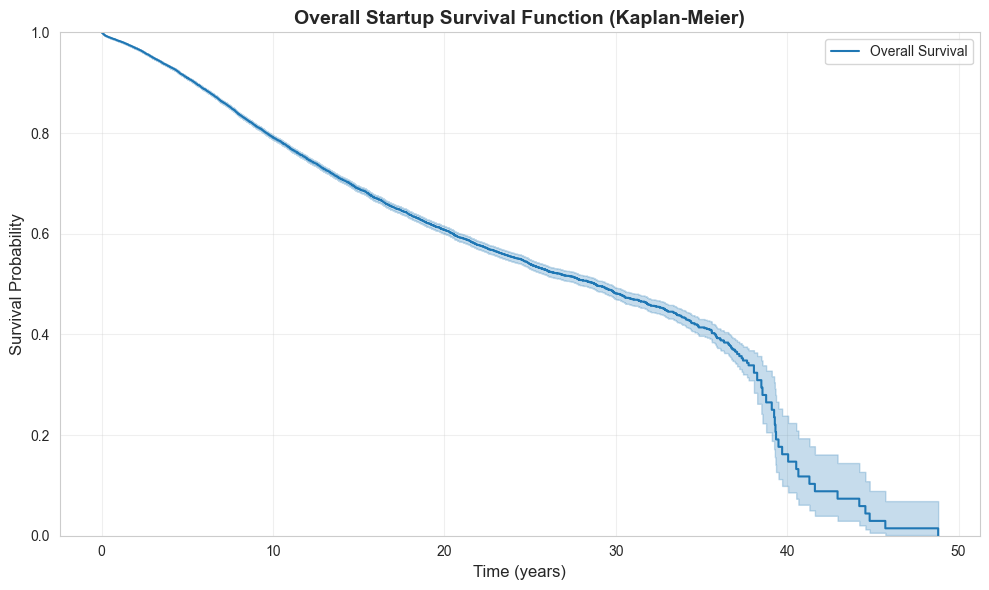

In [104]:
# ======================================================================
# PART 8: KAPLAN-MEIER SURVIVAL ANALYSIS
# ======================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print('\n' + '='*70)
print('PART 8: KAPLAN-MEIER SURVIVAL ANALYSIS')
print('='*70 + '\n')

# Global KM
kmf = KaplanMeierFitter()
kmf.fit(durations=master_final['duration_years'], 
        event_observed=master_final['event'],
        label='Overall Survival')

print('✓ Global Kaplan-Meier Fit')
print(f'  Median survival time: {kmf.median_survival_time_:.2f} years')
print(f'  Events observed: {master_final["event"].sum():,}')
print(f'  Censored: {(~master_final["event"].astype(bool)).sum():,}')

# Plot
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True)
plt.title('Overall Startup Survival Function (Kaplan-Meier)', fontsize=14, weight='bold')
plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



----------------------------------------------------------------------
KAPLAN-MEIER BY GEOGRAPHY
----------------------------------------------------------------------

US           | Median:  23.03 years | Events: 12,250 | Total: 68,080
UK           | Median:    inf years | Events:   253 | Total:  5,098
Canada       | Median:    inf years | Events:   164 | Total:  2,706
China        | Median:    inf years | Events:    28 | Total:    480
Other        | Median:    inf years | Events:   620 | Total: 18,326

Log-rank test p-value: 0.0000e+00


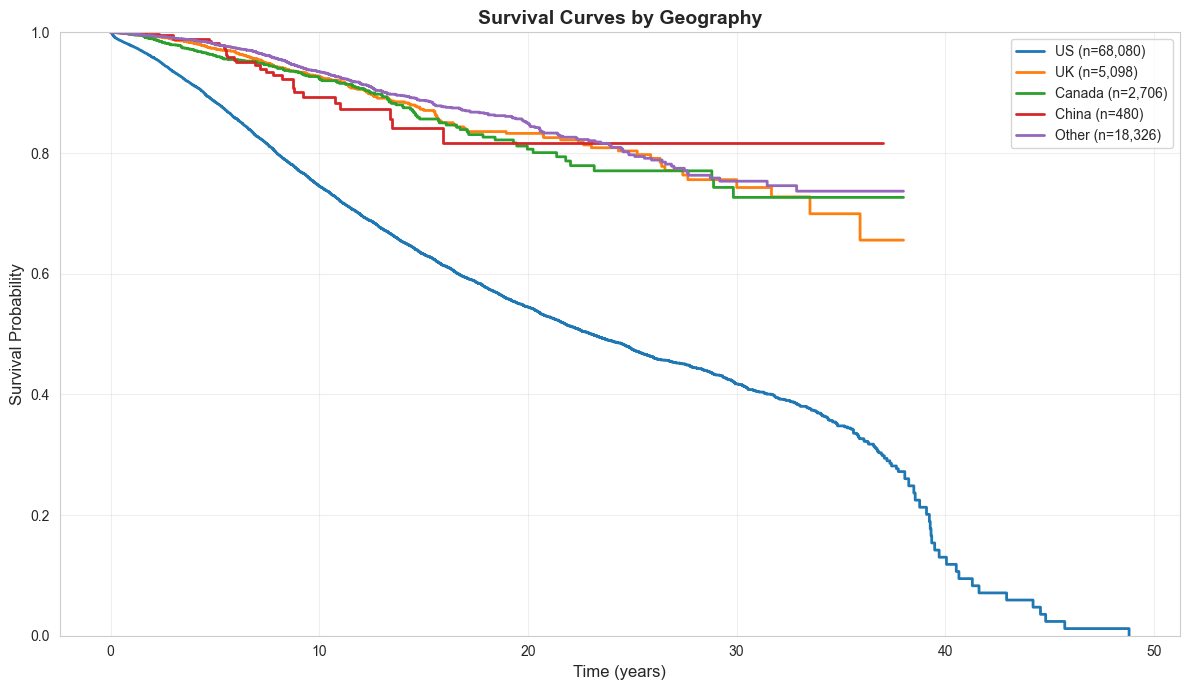

In [105]:
# ======================================================================
# KM BY GEOGRAPHY
# ======================================================================

print('\n' + '-'*70)
print('KAPLAN-MEIER BY GEOGRAPHY')
print('-'*70 + '\n')

fig, ax = plt.subplots(figsize=(12, 7))

geographies = ['US', 'UK', 'Canada', 'China', 'Other']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for geo, color in zip(geographies, colors):
    mask = master_final['geography'] == geo
    if mask.sum() > 0:
        kmf_geo = KaplanMeierFitter()
        kmf_geo.fit(durations=master_final.loc[mask, 'duration_years'],
                    event_observed=master_final.loc[mask, 'event'],
                    label=f'{geo} (n={mask.sum():,})')
        kmf_geo.plot_survival_function(ax=ax, ci_show=False, color=color, linewidth=2)
        
        median = kmf_geo.median_survival_time_
        print(f'{geo:12s} | Median: {median:6.2f} years | Events: {master_final.loc[mask, "event"].sum():5,} | Total: {mask.sum():6,}')

# Log-rank test
results = multivariate_logrank_test(
    master_final['duration_years'],
    master_final['geography'],
    master_final['event']
)
print(f'\nLog-rank test p-value: {results.p_value:.4e}')

ax.set_title('Survival Curves by Geography', fontsize=14, weight='bold')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Survival Probability', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()



----------------------------------------------------------------------
KAPLAN-MEIER BY SECTOR
----------------------------------------------------------------------

Software     | Median:  35.32 years | Events: 1,364 | Total: 19,300
Healthcare   | Median:    inf years | Events:   341 | Total:  4,094
FinTech      | Median:    inf years | Events:    71 | Total:  1,126
AI/ML        | Median:    inf years | Events:    22 | Total:    436
Other        | Median:  24.75 years | Events: 11,517 | Total: 69,734

Log-rank test p-value: 1.3968e-271


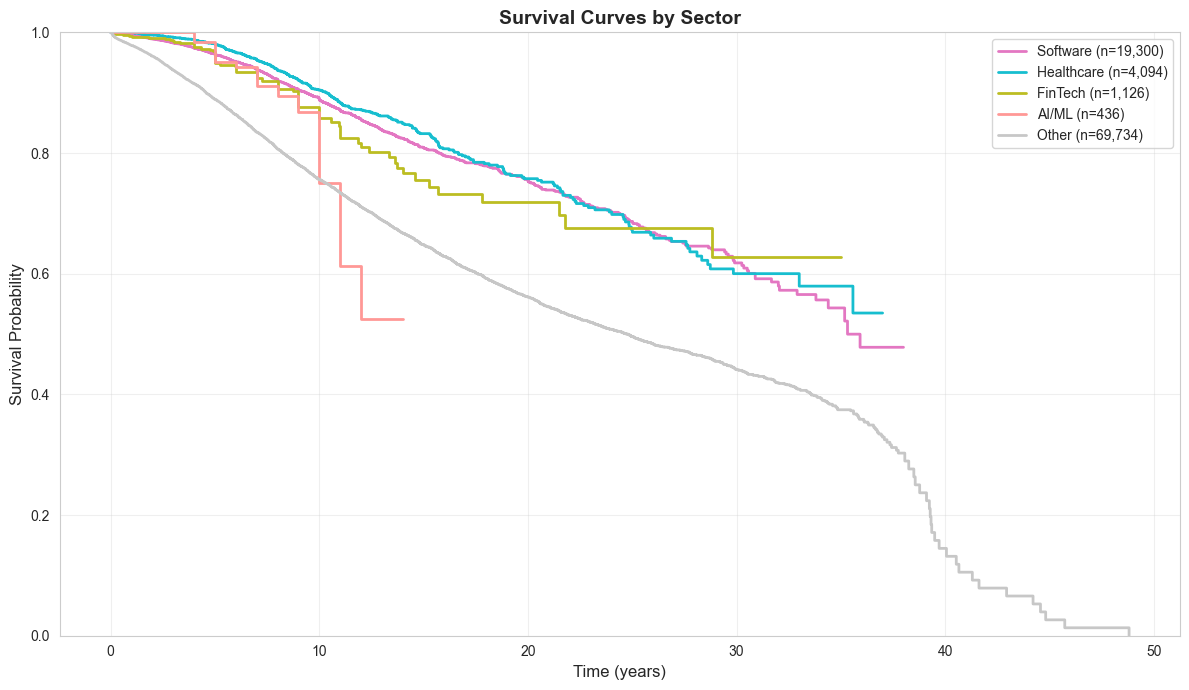

In [106]:
# ======================================================================
# KM BY SECTOR
# ======================================================================

print('\n' + '-'*70)
print('KAPLAN-MEIER BY SECTOR')
print('-'*70 + '\n')

fig, ax = plt.subplots(figsize=(12, 7))

sectors = ['Software', 'Healthcare', 'FinTech', 'AI/ML', 'Other']
colors_sector = ['#e377c2', '#17becf', '#bcbd22', '#ff9896', '#c7c7c7']

for sector, color in zip(sectors, colors_sector):
    mask = master_final['sector_clean'] == sector
    if mask.sum() > 0:
        kmf_sec = KaplanMeierFitter()
        kmf_sec.fit(durations=master_final.loc[mask, 'duration_years'],
                    event_observed=master_final.loc[mask, 'event'],
                    label=f'{sector} (n={mask.sum():,})')
        kmf_sec.plot_survival_function(ax=ax, ci_show=False, color=color, linewidth=2)
        
        median = kmf_sec.median_survival_time_
        print(f'{sector:12s} | Median: {median:6.2f} years | Events: {master_final.loc[mask, "event"].sum():5,} | Total: {mask.sum():6,}')

# Log-rank test
results_sector = multivariate_logrank_test(
    master_final['duration_years'],
    master_final['sector_clean'],
    master_final['event']
)
print(f'\nLog-rank test p-value: {results_sector.p_value:.4e}')

ax.set_title('Survival Curves by Sector', fontsize=14, weight='bold')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Survival Probability', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()



----------------------------------------------------------------------
KAPLAN-MEIER BY SOURCE
----------------------------------------------------------------------

Crunchbase_2013    | Median:    inf years | Events: 4,782 | Total: 83,394
Y_Combinator       | Median:  15.00 years | Events:   202 | Total:  2,965
Jay_Ritter         | Median:   5.09 years | Events: 8,331 | Total:  8,331

Log-rank test p-value: 0.0000e+00


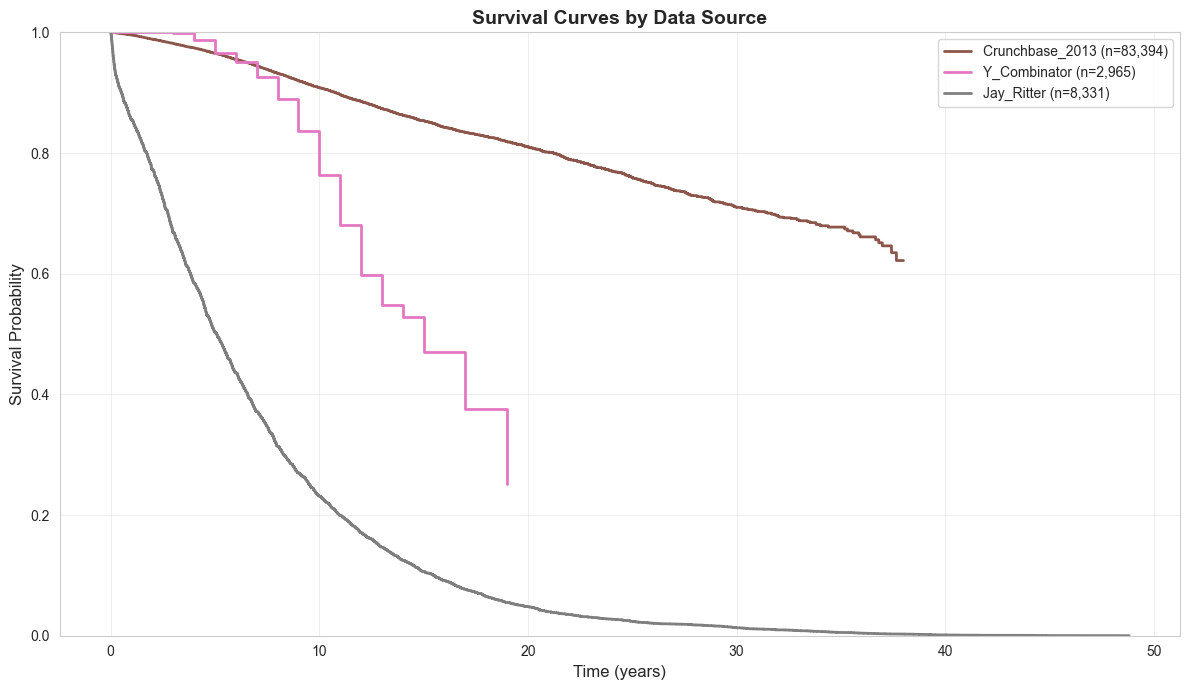


✓ Kaplan-Meier analysis complete!


In [107]:
# ======================================================================
# KM BY SOURCE
# ======================================================================

print('\n' + '-'*70)
print('KAPLAN-MEIER BY SOURCE')
print('-'*70 + '\n')

fig, ax = plt.subplots(figsize=(12, 7))

sources = ['Crunchbase_2013', 'Y_Combinator', 'Jay_Ritter']
colors_source = ['#8c564b', '#e377c2', '#7f7f7f']

for source, color in zip(sources, colors_source):
    mask = master_final['source'] == source
    if mask.sum() > 0:
        kmf_src = KaplanMeierFitter()
        kmf_src.fit(durations=master_final.loc[mask, 'duration_years'],
                    event_observed=master_final.loc[mask, 'event'],
                    label=f'{source} (n={mask.sum():,})')
        kmf_src.plot_survival_function(ax=ax, ci_show=False, color=color, linewidth=2)
        
        median = kmf_src.median_survival_time_
        print(f'{source:18s} | Median: {median:6.2f} years | Events: {master_final.loc[mask, "event"].sum():5,} | Total: {mask.sum():6,}')

# Log-rank test
results_source = multivariate_logrank_test(
    master_final['duration_years'],
    master_final['source'],
    master_final['event']
)
print(f'\nLog-rank test p-value: {results_source.p_value:.4e}')

ax.set_title('Survival Curves by Data Source', fontsize=14, weight='bold')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Survival Probability', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('\n✓ Kaplan-Meier analysis complete!')


In [108]:
# Diagnostica covariate per Cox PH
print('Covariate distribution for Cox PH:\n')

cox_vars = ['geography','sector_clean','funding_log','num_founders','post_2000']

for var in cox_vars:
    if var in master_final.columns:
        print(f'{var}:')
        print(f'  NaN: {master_final[var].isna().sum()}')
        if master_final[var].dtype in ['float64','int64']:
            print(f'  Range: [{master_final[var].min():.2f}, {master_final[var].max():.2f}]')
            print(f'  Mean: {master_final[var].mean():.2f}')
        else:
            print(f'  Categories: {master_final[var].nunique()}')
            print(f'  Top 3: {master_final[var].value_counts().head(3).to_dict()}')
        print()

Covariate distribution for Cox PH:

geography:
  NaN: 0
  Categories: 5
  Top 3: {'US': 68080, 'Other': 18326, 'UK': 5098}

sector_clean:
  NaN: 0
  Categories: 5
  Top 3: {'Other': 69734, 'Software': 19300, 'Healthcare': 4094}

funding_log:
  NaN: 0
  Range: [0.00, 9.76]
  Mean: 1.39

num_founders:
  NaN: 0
  Range: [0.00, 0.00]
  Mean: 0.00

post_2000:
  NaN: 0
  Range: [0.00, 1.00]
  Mean: 0.03



In [109]:
# Fix funding_log infiniti
master_final['funding_log'] = master_final['funding_log'].replace([float('-inf'), float('inf')], 0)
print(f'funding_log fixed: {(master_final["funding_log"] == 0).sum()} zeros')

funding_log fixed: 74017 zeros


In [110]:
# Subset per Cox: escludi Jay_Ritter per evitare bias
cox_data = master_final[master_final['source'] != 'Jay_Ritter'].copy()
print(f'Cox dataset: {len(cox_data):,} rows (excluded Jay_Ritter)')
print(f'Event rate: {cox_data["event"].mean()*100:.1f}%')

Cox dataset: 86,359 rows (excluded Jay_Ritter)
Event rate: 5.8%


In [111]:
# ======================================================================
# PART 9: COX PROPORTIONAL HAZARDS REGRESSION
# ======================================================================

from lifelines import CoxPHFitter
import pandas as pd
import numpy as np

print('\n' + '='*70)
print('PART 9: COX PROPORTIONAL HAZARDS REGRESSION')
print('='*70 + '\n')

# Prepara dati per Cox (escludi num_founders = 0 ovunque)
cox_df = cox_data[['duration_years', 'event', 'geography', 'sector_clean', 
                    'funding_log', 'post_2000']].copy()

# Encoding categoriche (reference: US, Other)
cox_df = pd.get_dummies(cox_df, columns=['geography', 'sector_clean'], drop_first=False)

# Drop reference categories per evitare multicollinearità
cox_df = cox_df.drop(columns=['geography_US', 'sector_clean_Other'], errors='ignore')

print(f'Cox dataset shape: {cox_df.shape}')
print(f'Covariates: {cox_df.shape[1] - 2}')  # -2 per duration e event
print(f'Events: {cox_df["event"].sum():,} / {len(cox_df):,} ({cox_df["event"].mean()*100:.1f}%)\n')

# Fit Cox PH
cph = CoxPHFitter(penalizer=0.001)  # small L2 penalty per stabilità numerica
cph.fit(cox_df, duration_col='duration_years', event_col='event')

print('✓ Cox PH Model Fitted')
print(f'  Concordance index: {cph.concordance_index_:.4f}')
print(f'  Log-likelihood: {cph.log_likelihood_:.2f}')
print(f'  AIC partial: {cph.AIC_partial_:.2f}\n')

# Summary table
summary = cph.summary[['coef', 'exp(coef)', 'se(coef)', 'p']]
summary.columns = ['Coefficient', 'Hazard Ratio', 'Std Error', 'p-value']
summary['Significant'] = summary['p-value'] < 0.05

print('Cox PH Coefficients (Hazard Ratios):')
print(summary.sort_values('p-value').to_string())


PART 9: COX PROPORTIONAL HAZARDS REGRESSION

Cox dataset shape: (86359, 12)
Covariates: 10
Events: 4,984 / 86,359 (5.8%)

✓ Cox PH Model Fitted
  Concordance index: 0.6278
  Log-likelihood: -49735.58


StatError: Since the model is semi-parametric (and not fully-parametric), the AIC does not exist. You probably want the `.AIC_partial_` property instead.

In [ ]:
# ======================================================================
# TEST PROPORTIONAL HAZARDS ASSUMPTION
# ======================================================================

print('\n' + '-'*70)
print('PROPORTIONAL HAZARDS ASSUMPTION TEST (Schoenfeld Residuals)')
print('-'*70 + '\n')

ph_test = cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=True)

print('\nInterpretation:')
print('- p > 0.05: assumption holds (good)')
print('- p < 0.05: assumption violated (hazard ratio changes over time)')

In [ ]:
# ======================================================================
# HAZARD RATIOS FOREST PLOT
# ======================================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Prepara dati per forest plot
hr_data = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
hr_data = hr_data.sort_values('exp(coef)')

# Color by significance
colors = ['red' if p < 0.001 else 'orange' if p < 0.05 else 'gray' 
          for p in hr_data['p']]

y_pos = np.arange(len(hr_data))
ax.errorbar(hr_data['exp(coef)'], y_pos, 
            xerr=[hr_data['exp(coef)'] - hr_data['exp(coef) lower 95%'],
                  hr_data['exp(coef) upper 95%'] - hr_data['exp(coef)']],
            fmt='o', color='black', ecolor=colors, elinewidth=2, capsize=4)

ax.axvline(1, color='black', linestyle='--', linewidth=1, label='No effect (HR=1)')
ax.set_yticks(y_pos)
ax.set_yticklabels(hr_data.index)
ax.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax.set_title('Cox PH Hazard Ratios (Reference: US, Other sector)', fontsize=14, weight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3, axis='x')
ax.legend()
plt.tight_layout()
plt.show()

print('\n✓ Cox PH analysis complete!')
